In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw,AllChem
from rdkit.Chem.rdmolops import ReplaceCore
from molop import AutoParser
from rdkit.Chem.Draw import IPythonConsole
import os
from rxnpred.geom.utils import clear_ferr_chirality
from copy import deepcopy

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600, 600
def frag2rad(smiles):
    rwmol = Chem.RWMol(Chem.MolFromSmiles(smiles))
    rwmol.RemoveAtom(0)
    rwmol.GetAtomWithIdx(0).SetNumRadicalElectrons(
        rwmol.GetAtomWithIdx(0).GetNumRadicalElectrons() + 1
    )
    return Chem.MolToSmiles(rwmol.GetMol())

def get_dedup_index_map(original_df, dedup_df):
    # 创建映射字典
    index_map = {}

    # 找到所有非重复（保留）行的索引
    kept_indices = dedup_df.index
    # 遍历每个保留的行索引
    for index in kept_indices:
        # 找到与当前保留行内容相同的所有行的索引
        matching_indices = original_df[(original_df.loc[index] == original_df).all(axis=1)].index
        # 去掉当前保留行的索引本身
        #removed_indices = matching_indices.drop(index)
        # 如果有去除的行，加入字典
        #if not removed_indices.empty:
        index_map[index] = list(matching_indices)
    return index_map

def canonical_smiles(smiles: str):
    original_smi = smiles
    viewed_smi = {original_smi: 1}
    while original_smi != (
        canonical_smi := Chem.CanonSmiles(original_smi, useChiral=True)
    ) and (canonical_smi not in viewed_smi or viewed_smi[canonical_smi] < 2):
        original_smi = canonical_smi
        if original_smi not in viewed_smi:
            viewed_smi[original_smi] = 1
        else:
            viewed_smi[original_smi] += 1
    else:
        return original_smi

def mod_title_in_gjf(gjf_file, new_title):
    with open(gjf_file, 'r') as f:
        lines = f.readlines()

    ## 定位到title行
    for i, line in enumerate(lines):
        if "#" in line:
            title_line = i + 2
            lines[title_line] = f'{new_title}\n'
            break
    with open(gjf_file, 'w') as f:
        f.writelines(lines)

def write_title(freeze_site,loc_site):
    title = "Freeze index"
    for idx_ in freeze_site:
        title += f"  {idx_}"
    title += " // Local index"
    for idx_ in loc_site:
        title += f"  {idx_}"
    return title

def get_amino_type_and_substituent_lst(lig_smi_lst, amino_structure, l_amino_substructure, d_amino_substructure):
    amino_type_lst = []
    for smi in lig_smi_lst:
        mol = Chem.MolFromSmiles(smi)
        if mol.HasSubstructMatch(amino_structure) and len(mol.GetAtomWithIdx(mol.GetSubstructMatch(amino_structure)[2]).GetNeighbors()) < 3:
            if mol.HasSubstructMatch(l_amino_substructure, useChirality=True):
                amino_type_lst.append("L")
            elif mol.HasSubstructMatch(d_amino_substructure, useChirality=True):
                amino_type_lst.append("D")
            else:
                amino_type_lst.append("NA")
        else:
            amino_type_lst.append("NA")
    amino_substituents = [Chem.MolToSmiles(ReplaceCore(Chem.MolFromSmiles(smi),amino_structure)) if type_ != "NA" else None for smi,type_ in zip(lig_smi_lst, amino_type_lst)]
    amino_substituents_rad = [[frag2rad(sub_smi) for sub_smi in smi.split('.') if sub_smi != ""] if smi != None else None for smi in amino_substituents]
    # 对取代基进行对齐
    amino_sub_num_lst = [len(item) for item in amino_substituents_rad if item != None]
    max_amino_sub_num = max(amino_sub_num_lst) if amino_sub_num_lst else 0
    amino_substituents_rad_align = []
    for item in amino_substituents_rad:
        if item == None:
            amino_substituents_rad_align.append(None)
        else:
            amino_substituents_rad_align.append(item + ["[H]" for _ in range(max_amino_sub_num - len(item))])
    return amino_type_lst, amino_substituents_rad_align, max_amino_sub_num

def get_ferr_type_and_substituent_lst(rct1_smi_lst, core_fe_1, core_fe_2=None):
    fe_type_lst = []
    fe_substituents = []
    for smi in rct1_smi_lst:
        mol = Chem.MolFromSmiles(smi)
        if mol.HasSubstructMatch(core_fe_1):
            fe_type_lst.append(1)
            fe_substituents.append(Chem.MolToSmiles(ReplaceCore(Chem.MolFromSmiles(smi),core_fe_1)))
        elif core_fe_2 != None and mol.HasSubstructMatch(core_fe_2):
            fe_type_lst.append(2)
            fe_substituents.append(Chem.MolToSmiles(ReplaceCore(Chem.MolFromSmiles(smi),core_fe_2)))
        else:
            fe_type_lst.append("NA")
            fe_substituents.append(None)
    fe_substituents_rad = [[frag2rad(sub_smi) for sub_smi in smi.split('.') if sub_smi != ""] if smi != None else None for smi in fe_substituents]
    max_ferr_sub_num = max([len(item) for item in fe_substituents_rad if item != None])
    fe_substituents_rad_align = []
    for item in fe_substituents_rad:
        if item == None:
            fe_substituents_rad_align.append(None)
        else:
            fe_substituents_rad_align.append(item + ["[H]" for _ in range(max_ferr_sub_num - len(item))])
    return fe_type_lst, fe_substituents_rad_align, max_ferr_sub_num

def dedup_and_ret_sub_table(rct1_smi_lst,lig_smi_lst,amino_type_lst,fe_type_lst,fe_substituents_rad_align,amino_substituents_rad_align,max_ferr_sub_num,max_amino_sub_num):
    sub_info_map = {"amino_type":[],"fe_type":[]}
    ori_smi_map = {"rct1":[],"lig":[]}
    for _ in range(max_ferr_sub_num):
        sub_info_map[f"fe_sub_{_}"] = []
    for _ in range(max_amino_sub_num):
        sub_info_map[f"amino_sub_{_}"] = []
    for amino_type_, fe_type_, fe_sub, amino_sub,rct1,lig in zip(amino_type_lst,fe_type_lst,fe_substituents_rad_align,amino_substituents_rad_align,rct1_smi_lst,lig_smi_lst):
        if amino_type_ == "NA" or fe_type_ == "NA" or fe_sub == None or amino_sub == None:
            continue
        sub_info_map["amino_type"].append(amino_type_)
        sub_info_map["fe_type"].append(fe_type_)
        for idx,sub in enumerate(fe_sub):
            sub_info_map[f"fe_sub_{idx}"].append(sub)
        for idx,sub in enumerate(amino_sub):
            sub_info_map[f"amino_sub_{idx}"].append(sub)
        ori_smi_map["rct1"].append(rct1)
        ori_smi_map["lig"].append(lig)
    sub_info_df = pd.DataFrame(sub_info_map)
    ori_smi_df = pd.DataFrame(ori_smi_map)
    sub_info_df_dep = sub_info_df.drop_duplicates()
    dep_index_map = get_dedup_index_map(sub_info_df, sub_info_df_dep)
    smi_idx_map = {}
    for key in dep_index_map:
        smi_lst = [",".join(list(ori_smi_df.iloc[idx])) for idx in dep_index_map[key]]
        for smi in smi_lst:
            smi_idx_map[smi] = key
    return sub_info_df_dep, smi_idx_map

def write_map(inf_map,file,title_lst=["smiles_pair","index"]):
    with open(file,"w") as fw:
        fw.write(",".join(title_lst)+"\n")
        for key,value in inf_map.items():
            fw.write(f"'{key}',{value}\n")

def load_map(map_file):
    inf_map = {}
    with open(map_file,'r') as f:
        lines = f.readlines()
    #print(len(lines)-1)
    for line in lines[1:]:
        smiles = line.strip().split("'")[1]
        index = line.strip().split("'")[2].split(',')[1]
        inf_map[smiles] = int(index)
    return inf_map

def read_rct_and_lig(data_df,rct_col_name="Reactant2 Smiles",lig_col_name="Catalyst2 Smiles"):
    lig_smi_lst,rct1_smi_lst = data_df[lig_col_name].to_list(),data_df[rct_col_name].to_list()
    lig_smi_lst = [canonical_smiles(smi) for smi in lig_smi_lst]
    rct1_smi_lst = [canonical_smiles(smi) for smi in rct1_smi_lst]
    lig_rct1_pair_set = set(zip(lig_smi_lst,rct1_smi_lst))
    lig_smi_lst = [item[0] for item in lig_rct1_pair_set]
    rct1_smi_lst = [item[1] for item in lig_rct1_pair_set]
    return rct1_smi_lst,lig_smi_lst

In [4]:
# read TS template
ts_template_Rp_file = "../templated_TS/Template-Rp.gjf"
ts_template_Sp_file = "../templated_TS/Template-Sp.gjf"
ts_template_Rp_file2 = "../templated_TS/Template-Rp2.gjf"
ts_template_Sp_file2 = "../templated_TS/Template-Sp2.gjf"

loc_site_in_template1 = [3,18,20,33,(20,),[11,18],[18,19]]      # 1-index
freeze_site_in_template1 = [[11,18],[18,19],[3,19],[3,33],[3,28],[3,21]]   # 1-index
loc_site_in_template2 = [3,18,20,32,(20,),[11,18],[18,19]]      # 1-index
freeze_site_in_template2 = [[11,18],[18,19],[3,19],[3,32],[3,28],[3,21]]   # 1-index

template_rp = AutoParser(ts_template_Rp_file)[0][0]
template_sp = AutoParser(ts_template_Sp_file)[0][0]
template_rp2 = AutoParser(ts_template_Rp_file2)[0][0]
template_sp2 = AutoParser(ts_template_Sp_file2)[0][0]

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 124.04it/s]
INFO - 0 files failed to parse, 1 successfully parsed
MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 113.82it/s]
INFO - 0 files failed to parse, 1 successfully parsed
MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 142.18it/s]
INFO - 0 files failed to parse, 1 successfully parsed
MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 124.22it/s]
INFO - 0 files failed to parse, 1 successfully parsed


## Case 1 (Ferrocene with CX<sub>4</sub>)

In [13]:
amino_structure = Chem.MolFromSmarts("O=CNCC(=O)O")
l_amino_substructure = Chem.MolFromSmarts("N[C@@H]([#6])C(=O)O")
d_amino_substructure = Chem.MolFromSmarts("N[C@H]([#6])C(=O)O")
core_fe_1 = Chem.MolFromSmarts("[CX4]-C12C3C4C5C1[Fe]23451678C2C1C6C7C28")
core_fe_2 = Chem.MolFromSmarts("O=C-C12C3C4C5C1[Fe]23451678C2C1C6C7C28")
core_fe = Chem.MolFromSmiles("CCCCN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39")
core_animo = amino_structure

In [24]:
data_file = "../data/sel_base_data_clean.csv"
data_df = pd.read_csv(data_file)

In [25]:
data_df

,Unnamed: 0,Reactant1,Reactant2,Solvents,Solvent1,Solvent2,Reagents,Reagent1,Reagent2,Reagent3,Reagent4,Reagent5,ddG,ee,index,temperature
0,0,O=C(C(=O)c1ccc(-c2ccccc2)cc1)c1ccc(-c2ccccc2)cc1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,C1CCOC1,C1CCOC1,NaN,CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.CC(=O)[O-].CC(=...,O=C([O-])[O-].[K+].[K+],CCCC[N+](CCCC)(CCCC)CCCC.[Br-],CC(C)(C)OO,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC(=O)N[C@@H](Cc1ccccc1)C(=O)O,2.733668,0.96,0,80
1,1,Cc1ccc(C(=O)C(=O)c2ccc(C)cc2)cc1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,C1CCOC1,C1CCOC1,NaN,CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.CC(=O)[O-].CC(=...,O=C([O-])[O-].[K+].[K+],CCCC[N+](CCCC)(CCCC)CCCC.[Br-],CC(C)(C)OO,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC(=O)N[C@@H](Cc1ccccc1)C(=O)O,3.227675,0.98,1,80
2,2,O=C(C(=O)c1ccccc1)c1ccccc1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,C1CCOC1,C1CCOC1,NaN,CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.CC(=O)[O-].CC(=...,O=C([O-])[O-].[K+].[K+],CCCC[N+](CCCC)(CCCC)CCCC.[Br-],CC(C)(C)OO,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC(=O)N[C@@H](Cc1ccccc1)C(=O)O,2.733668,0.96,2,80
3,3,O=C(C(=O)c1ccccc1)c1ccccc1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,C1CCOC1,C1CCOC1,NaN,CC(=O)N[C@H](Cc1ccccc1)C(=O)O.CC(=O)[O-].CC(=O...,O=C([O-])[O-].[K+].[K+],CCCC[N+](CCCC)(CCCC)CCCC.[Br-],CC(C)(C)OO,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC(=O)N[C@H](Cc1ccccc1)C(=O)O,3.227675,0.98,3,80
4,4,Cc1cccc(C(=O)C(=O)c2cccc(C)c2)c1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,C1CCOC1,C1CCOC1,NaN,CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.CC(=O)[O-].CC(=...,O=C([O-])[O-].[K+].[K+],CCCC[N+](CCCC)(CCCC)CCCC.[Br-],CC(C)(C)OO,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC(=O)N[C@@H](Cc1ccccc1)C(=O)O,2.939314,0.97,4,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,463,c1ccc2occc2c1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,CC(=O)N(C)C,CC(=O)N(C)C,NaN,CC(=O)[O-].CC(=O)[O-].CC[C@H](C)[C@H](NC(=O)OC...,O=C([O-])[O-].[K+].[K+],O=C1C=CC(=O)C=C1,NaN,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O,3.718090,0.99,829,80
442,464,c1ccc2occc2c1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7C28,CC(=O)N(C)C,CC(=O)N(C)C,NaN,CC(=O)[O-].CC(=O)[O-].CC[C@H](C)[C@H](NC(=O)OC...,O=C([O-])[O-].[K+].[K+],O=C1C=CC(=O)C=C1,NaN,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O,3.718090,0.99,830,80
443,465,c1ccc2occc2c1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7(P(=O)(c1...,CC(=O)N(C)C,CC(=O)N(C)C,NaN,CC(=O)[O-].CC(=O)[O-].CC[C@H](C)[C@H](NC(=O)OC...,O=C([O-])[O-].[K+].[K+],O=C1C=CC(=O)C=C1,NaN,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O,3.718090,0.99,832,80
444,466,c1ccc2occc2c1,CN(C)CC12C3C4C5C1[Fe]45321678C2C1C6C7([Si](C)(...,CC(=O)N(C)C,CC(=O)N(C)C,NaN,CC(=O)[O-].CC(=O)[O-].CC[C@H](C)[C@H](NC(=O)OC...,O=C([O-])[O-].[K+].[K+],O=C1C=CC(=O)C=C1,NaN,CC(=O)[O-].CC(=O)[O-].[Pd+2],CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O,2.939314,0.97,835,80


In [27]:
rct1_smi_lst,lig_smi_lst = read_rct_and_lig(data_df, rct_col_name="Reactant2",lig_col_name="Reagent5")
# get substituent variation info for different ferrocene and amino
amino_type_lst, amino_substituents_rad_align, max_amino_sub_num = get_amino_type_and_substituent_lst(lig_smi_lst, amino_structure, l_amino_substructure, d_amino_substructure)
fe_type_lst, fe_substituents_rad_align, max_ferr_sub_num = get_ferr_type_and_substituent_lst(rct1_smi_lst, core_fe_1, core_fe_2)
# dedup and get index map
sub_info_df_dep, smi_idx_map = dedup_and_ret_sub_table(rct1_smi_lst,lig_smi_lst,amino_type_lst,fe_type_lst,fe_substituents_rad_align,amino_substituents_rad_align,max_ferr_sub_num,max_amino_sub_num)

In [28]:
sub_info_df_dep

,amino_type,fe_type,fe_sub_0,fe_sub_1,amino_sub_0,amino_sub_1
0,L,1,C[N]C,[H],CC(C)(C)[O],C[CH]C
1,L,1,CC[N]CC,[H],CC(C)(C)[O],C[CH]CC
2,L,2,[OH],[H],[O]Cc1ccccc1,[CH2]c1ccccc1
3,L,2,[OH],[H],CC(C)(C)[O],C[CH]C
4,L,2,[OH],[H],[O]Cc1ccccc1,C[CH]CC
...,...,...,...,...,...,...
61,D,2,[OH],[H],[CH3],[CH2]c1ccccc1
62,L,1,C[N]C,[H],CC(C)(C)[O],[c]1ccccc1
63,L,1,C1COCC[N]1,[H],CC(C)(C)[O],C[CH]C
64,L,1,C[N]C,[H],[O]Cc1ccccc1,C[CH]CC


In [39]:
amino_type_lst, amino_substituents_rad_align, max_amino_sub_num = get_amino_type_and_substituent_lst(['O=C(N[C@@H](Cc1ccccc1)C(=O)O)Oc1ccccc1'], amino_structure, l_amino_substructure, d_amino_substructure)
fe_type_lst, fe_substituents_rad_align, max_ferr_sub_num = get_ferr_type_and_substituent_lst(['CC(N(C)C)C12C3C4C5C1[Fe]45321678C2C1C6C7C28'], core_fe_1, core_fe_2)

In [54]:
fe_type_lst = []
fe_substituents = []
smi = 'CC(N(C)C)C12C3C4C5C1[Fe]45321678C2C1C6C7C28'
mol = Chem.MolFromSmiles(smi)
mol.HasSubstructMatch(core_fe_1)
mol_blks = ReplaceCore(Chem.MolFromSmiles(smi),core_fe_1)

In [60]:
Chem.MolToSmiles(mol_blks)

'[1*]N(C)C.[2*]C'

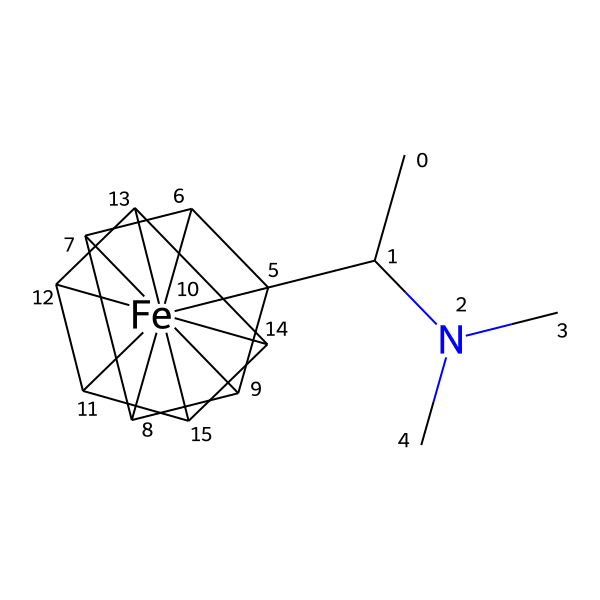

In [53]:
mol

In [48]:
mol.GetSubstructMatch(core_fe_1)

(1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

In [ ]:
    if mol.HasSubstructMatch(core_fe_1):
        fe_type_lst.append(1)
        fe_substituents.append(Chem.MolToSmiles(ReplaceCore(Chem.MolFromSmiles(smi),core_fe_1)))

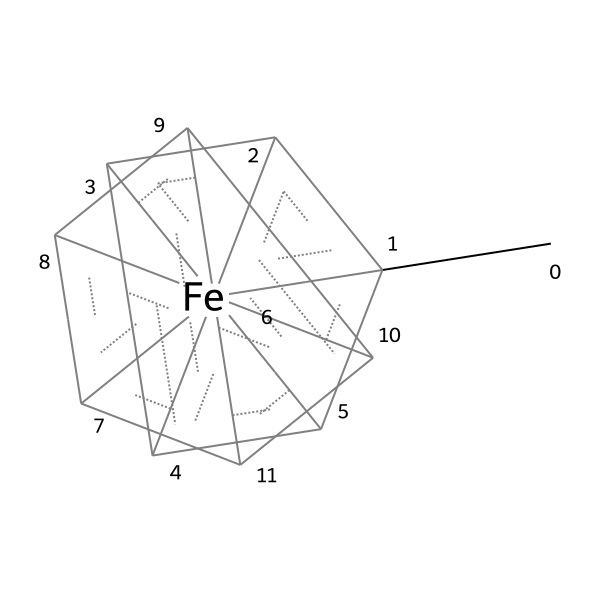

In [44]:
core_fe_1

In [46]:
fe_substituents_rad_align

[['[CH3]', 'C[N]C']]

In [30]:
## generate initial transition state geometry
for idx,amino_type_,fe_type_,amino_sub_0,amino_sub_1,fe_sub_0,fe_sub_1 in zip(sub_info_df_dep.index.to_list(),sub_info_df_dep["amino_type"].to_list(),sub_info_df_dep["fe_type"].to_list(),
                                                                          sub_info_df_dep["amino_sub_0"].to_list(),sub_info_df_dep["amino_sub_1"].to_list(),
                                                                          sub_info_df_dep["fe_sub_0"].to_list(),sub_info_df_dep["fe_sub_1"].to_list()):
    fe_sub = [fe_sub_0,fe_sub_1]
    amino_sub = [amino_sub_0,amino_sub_1]
    if amino_type_ == "L":
        #for a_sub in amino_sub:
        if fe_type_ == 1:
            ts_like_rp = (template_rp
                        .replace_substituent("[H]", fe_sub[1], bind_idx=34, angle_split=20)
                        .replace_substituent("[H]", fe_sub[0], bind_idx=32, angle_split=20)
                        .replace_substituent("[H]", amino_sub[1], bind_idx=29, angle_split=20)
                        .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            ts_like_sp = (template_sp
                        .replace_substituent("[H]", fe_sub[1], bind_idx=34, angle_split=20)
                        .replace_substituent("[H]", fe_sub[0], bind_idx=32, angle_split=20)
                        .replace_substituent("[H]", amino_sub[1], bind_idx=29, angle_split=20)
                        .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            title = write_title(freeze_site_in_template1,loc_site_in_template1)
        elif fe_type_ == 2:
            print(idx,fe_sub)
            # for special case
            if fe_sub[0] == '[OH]':
                fe_sub[0] = '[O-]'
            ts_like_rp = (template_rp2
                .replace_substituent("[H]", fe_sub[0], bind_idx=31, angle_split=20)
                .replace_substituent("[H]", amino_sub[1], bind_idx=29, angle_split=20)
                .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            ts_like_sp = (template_sp2
                .replace_substituent("[H]", fe_sub[0], bind_idx=31, angle_split=20)
                .replace_substituent("[H]", amino_sub[1], bind_idx=29, angle_split=20)
                .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            title = write_title(freeze_site_in_template2,loc_site_in_template2)
        else:
            continue
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}_{fe_type_}.gjf"
        ts_like_rp.to_GJF_file(
            f"../gen_TS/rp_{idx}_{fe_type_}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"../gen_TS/rp_{idx}_{fe_type_}.gjf", title) 
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}_{fe_type_}.gjf"
        ts_like_sp.to_GJF_file(
            f"../gen_TS/sp_{idx}_{fe_type_}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"../gen_TS/sp_{idx}_{fe_type_}.gjf", title)
        
    elif amino_type_ == "D":
        if fe_type_ == 1:
            ts_like_rp = (template_rp
                        .replace_substituent("[H]", fe_sub[1], bind_idx=34, angle_split=20)
                        .replace_substituent("[H]", fe_sub[0], bind_idx=32, angle_split=20)
                        .replace_substituent("[H]", amino_sub[1], bind_idx=30, angle_split=20)
                        .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            ts_like_sp = (template_sp
                        .replace_substituent("[H]", fe_sub[1], bind_idx=34, angle_split=20)
                        .replace_substituent("[H]", fe_sub[0], bind_idx=32, angle_split=20)
                        .replace_substituent("[H]", amino_sub[1], bind_idx=30, angle_split=20)
                        .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            title = write_title(freeze_site_in_template1,loc_site_in_template1)
        elif fe_type_ == 2:
            # for special case
            if fe_sub[0] == '[OH]':
                fe_sub[0] = '[O-]'
            ts_like_rp = (template_rp2
                .replace_substituent("[H]", fe_sub[0], bind_idx=31, angle_split=20)
                .replace_substituent("[H]", amino_sub[1], bind_idx=30, angle_split=20)
                .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            ts_like_sp = (template_sp2
                .replace_substituent("[H]", fe_sub[0], bind_idx=31, angle_split=20)
                .replace_substituent("[H]", amino_sub[1], bind_idx=30, angle_split=20)
                .replace_substituent("[H]", amino_sub[0], bind_idx=28, angle_split=20)
            )
            title = write_title(freeze_site_in_template2,loc_site_in_template2)
        else:
            continue
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}_{fe_type_}.gjf"
        ts_like_rp.to_GJF_file(
            f"../gen_TS/rp_{idx}_{fe_type_}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"../gen_TS/rp_{idx}_{fe_type_}.gjf", title)
        
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}_{fe_type_}.gjf"
        ts_like_sp.to_GJF_file(
            f"../gen_TS/sp_{idx}_{fe_type_}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"../gen_TS/sp_{idx}_{fe_type_}.gjf", title)

2 ['[OH]', '[H]']
3 ['[OH]', '[H]']
4 ['[OH]', '[H]']
11 ['[OH]', '[H]']
13 ['[OH]', '[H]']
15 ['[OH]', '[H]']
25 ['[OH]', '[H]']
28 ['[OH]', '[H]']
29 ['[OH]', '[H]']
32 ['[OH]', '[H]']
34 ['[OH]', '[H]']
40 ['[OH]', '[H]']
41 ['[OH]', '[H]']
45 ['[OH]', '[H]']
48 ['[OH]', '[H]']
49 ['[OH]', '[H]']
53 ['[OH]', '[H]']


## Case 2

In [162]:
## 读取此前生成的SMILES索引映射（如有）
if os.path.exists("/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/smi_idx_map.csv"):
    pre_smi_idx_map = load_map("/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/smi_idx_map.csv")
else:
    pre_smi_idx_map = {}
cur_final_idx = max(pre_smi_idx_map.values()) if pre_smi_idx_map else 0

In [ ]:
# 定义核心结构
amino_structure = Chem.MolFromSmarts("O=CNCC(=O)O")
l_amino_substructure = Chem.MolFromSmarts("N[C@@H]([#6])C(=O)O")
d_amino_substructure = Chem.MolFromSmarts("N[C@H]([#6])C(=O)O")
core_fe = Chem.MolFromSmiles("CCCCN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39")
core_animo = amino_structure

In [164]:
# 读取过渡态模板
ts_template_Rp_file = "/mnt/e/SAIS/Project/SIOC/template/templated_TS/cyclo-TS-Rp_C-H-act-template.gjf"
ts_template_Sp_file = "/mnt/e/SAIS/Project/SIOC/template/templated_TS/cyclo-TS-Sp_C-H_act-template.gjf"
template_rp = AutoParser(ts_template_Rp_file)[0][0]
template_sp = AutoParser(ts_template_Sp_file)[0][0]

loc_site_in_template1 = [30,38,34,11,(34,),[37,38],[1,38]]      # 1-index
freeze_site_in_template1 = [[38,37],[38,1],[30,11],[30,1],[30,32],[30,31]]   # 1-index

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 148.22it/s]
INFO - 0 files failed to parse, 1 successfully parsed
MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 139.13it/s]
INFO - 0 files failed to parse, 1 successfully parsed


In [165]:
## 加载数据
data_file = "/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/副本二茂铁环胺偶联反应数据收集_赵方诺_processed.xlsx"
data_df = pd.read_excel(data_file)
rct1_smi_lst_,lig_smi_lst_ = read_rct_and_lig(data_df, rct_col_name="reactant_1_smiles",lig_col_name="ligand smiles")
rct1_smi_lst,lig_smi_lst = [],[]
for idx,(rsmi,lsmi) in enumerate(zip(rct1_smi_lst_,lig_smi_lst_)):
    if not f"{rsmi},{lsmi}" in pre_smi_idx_map:
        rct1_smi_lst.append(rsmi)
        lig_smi_lst.append(lsmi)

In [166]:
for idx,smi in enumerate(data_df["ligand smiles"].to_list()):
    if canonical_smiles(smi) in lig_smi_lst:
        print(idx,smi)

6 O=C(O)C(NC(=O)C)CC=1C=CC=CC1
7 O=C(O)C(NC(=O)C=1C=CC=CC1)CC=2C=CC=CC2
8 O=C(O)C(NC(=O)OCC=1C=CC=CC1)CC=2C=CC=CC2
17 O=C([C@@H](NC(OC(C)(C)C)=O)C1=CC=CC=C1)O
18 CC(OC(N1CCC[C@H]1C(O)=O)=O)(C)C
20 CC(OC(N[C@@H](CC(O)=O)CC1=CC=CC=C1)=O)(C)C
21 O=C(OCC1C=2C=CC=CC2C=3C=CC=CC31)NC(C(=O)O)CC=4C=CC=CC4


In [170]:
## 获取不同二茂铁与氨基酸的取代基变化信息
amino_type_lst, amino_substituents_rad_align, max_amino_sub_num = get_amino_type_and_substituent_lst(lig_smi_lst, amino_structure, l_amino_substructure, d_amino_substructure)
fe_type_lst, fe_substituents_rad_align, max_ferr_sub_num = get_ferr_type_and_substituent_lst(rct1_smi_lst, core_fe)
## 去重
sub_info_df_dep, smi_idx_map = dedup_and_ret_sub_table(rct1_smi_lst,lig_smi_lst,amino_type_lst,fe_type_lst,fe_substituents_rad_align,amino_substituents_rad_align,max_ferr_sub_num,max_amino_sub_num)
new_smi_idx_map = deepcopy(pre_smi_idx_map)
for smi,_idx in smi_idx_map.items():
    idx = cur_final_idx + _idx + 1
    new_smi_idx_map[f"{smi}"] = idx
write_map(new_smi_idx_map,"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/smi_idx_map.csv",title_lst=["smiles_pair","index"])

In [171]:
for _idx,amino_type,fe_type,amino_sub_0,amino_sub_1 in zip(sub_info_df_dep.index.tolist(),sub_info_df_dep["amino_type"].to_list(),
                                                          sub_info_df_dep["fe_type"].to_list(),sub_info_df_dep["amino_sub_0"].to_list(),
                                                          sub_info_df_dep["amino_sub_1"].to_list()):
    idx = cur_final_idx + _idx + 1
    print(idx)
    title = write_title(freeze_site_in_template1,loc_site_in_template1)
    # fe_sub is empty
    amino_sub = [amino_sub_0,amino_sub_1]
    if amino_type == "L":
        #for a_sub in amino_sub:
        ts_like_rp = template_rp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=39, angle_split=20)
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}.gjf"
        ts_like_rp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/rp_{idx}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/rp_{idx}.gjf",title)
        ts_like_sp = template_sp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=39, angle_split=20)
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}.gjf"
        ts_like_sp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/sp_{idx}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/sp_{idx}.gjf",title)
    elif amino_type == "D":
        ts_like_rp = template_rp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=38, angle_split=20)
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}.gjf"
        ts_like_rp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/rp_{idx}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/rp_{idx}.gjf",title)
        ts_like_sp = template_sp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=38, angle_split=20)
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}.gjf"
        ts_like_sp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/sp_{idx}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_2/sp_{idx}.gjf",title)

17


## Case 3

In [18]:
## 读取此前生成的SMILES索引映射（如有）
if os.path.exists("/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/smi_idx_map.csv"):
    pre_smi_idx_map = load_map("/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/smi_idx_map.csv")
else:
    pre_smi_idx_map = {}
cur_final_idx = max(pre_smi_idx_map.values()) if pre_smi_idx_map else 0
cur_final_idx

0

In [19]:
# 定义核心结构
amino_structure = Chem.MolFromSmarts("O=CNCC(=O)O")
#amino_structure = Chem.MolFromSmarts("[#8]=[#6]-[#7](-[#1])-[#6]-[#6](=[#8])-[#8]")
l_amino_substructure = Chem.MolFromSmarts("N[C@@H]([#6])C(=O)O")
d_amino_substructure = Chem.MolFromSmarts("N[C@H]([#6])C(=O)O")
core_fe = Chem.MolFromSmiles("CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39")
core_animo = amino_structure

In [20]:
# 读取过渡态模板
ts_template_Rp_file = "/mnt/e/SAIS/Project/SIOC/template/templated_TS/cyclo-TS-Rp_C-H-act-template.gjf"
ts_template_Sp_file = "/mnt/e/SAIS/Project/SIOC/template/templated_TS/cyclo-TS-Sp_C-H_act-template.gjf"
template_rp = AutoParser(ts_template_Rp_file)[0][0]
template_sp = AutoParser(ts_template_Sp_file)[0][0]

loc_site_in_template1 = [30,38,34,11,(34,),[37,38],[1,38]]      # 1-index
freeze_site_in_template1 = [[38,37],[38,1],[30,11],[30,1],[30,32],[30,31]]   # 1-index

MolOP parsing with single thread:   0%|          | 0/1 [00:00<?, ?it/s]

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]
INFO - 0 files failed to parse, 1 successfully parsed
MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 114.55it/s]
INFO - 0 files failed to parse, 1 successfully parsed


In [21]:
## 加载数据
data_file = "/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/副本赵方诺数据整理_20241006_processed.xlsx"
data_df = pd.read_excel(data_file)

rct1_smi_lst_,lig_smi_lst_ = read_rct_and_lig(data_df, rct_col_name="reactant_1_smiles",lig_col_name="ligand_smiles")

rct1_smi_lst,lig_smi_lst = [],[]
for idx,(rsmi,lsmi) in enumerate(zip(rct1_smi_lst_,lig_smi_lst_)):
    if not f"{rsmi},{lsmi}" in pre_smi_idx_map:
        rct1_smi_lst.append(rsmi)
        lig_smi_lst.append(lsmi)
        
rct1_smi_lst = [clear_ferr_chirality(smi) for smi in rct1_smi_lst]
#Chem.MolToSmiles(ReplaceCore(Chem.MolFromSmiles(smi),core_fe))

In [30]:
lig_smi_lst[0]

'CC(C)(C)OC(=O)N[C@@H](CC1CC1)C(=O)O'

In [31]:
sub_info_df_dep

,amino_type,fe_type,amino_sub_0,amino_sub_1
0,L,1,CC(C)(C)[O],[CH2]C1CC1
1,L,1,CC(C)(C)[O],[CH2]C(C)C
2,L,1,CC(C)(C)[O],[CH2]c1ccccc1C
3,L,1,CC(C)(C)[O],[CH2]c1ccc(OCc2ccccc2)cc1
4,L,1,CC(C)(C)[O],[CH]1CC1
5,L,1,CC(C)(C)[O],[CH2]C
6,L,1,CC(C)(C)[O],[CH2]c1ccccc1
7,L,1,CC(C)(C)[O],[CH2]CC(=O)OC(C)(C)C
8,L,1,[c]1ccccc1,[CH2]c1ccccc1
9,L,1,CC(C)(C)[O],[CH2]c1ccc(OC(=O)OC(C)(C)C)cc1


In [25]:
## 获取不同二茂铁与氨基酸的取代基变化信息
amino_type_lst, amino_substituents_rad_align, max_amino_sub_num = get_amino_type_and_substituent_lst(lig_smi_lst, amino_structure, l_amino_substructure, d_amino_substructure)
fe_type_lst, fe_substituents_rad_align, max_ferr_sub_num = get_ferr_type_and_substituent_lst(rct1_smi_lst, core_fe)
## 去重
sub_info_df_dep, smi_idx_map = dedup_and_ret_sub_table(rct1_smi_lst,lig_smi_lst,amino_type_lst,fe_type_lst,fe_substituents_rad_align,amino_substituents_rad_align,max_ferr_sub_num,max_amino_sub_num)
new_smi_idx_map = deepcopy(pre_smi_idx_map)
for smi,_idx in smi_idx_map.items():
    idx = cur_final_idx + _idx + 1
    new_smi_idx_map[f"{smi}"] = idx
    
write_map(new_smi_idx_map,"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/smi_idx_map.csv",title_lst=["smiles_pair","index"])

In [28]:
for _idx,amino_type,fe_type,amino_sub_0,amino_sub_1 in zip(sub_info_df_dep.index.tolist(),sub_info_df_dep["amino_type"].to_list(),
                                                          sub_info_df_dep["fe_type"].to_list(),sub_info_df_dep["amino_sub_0"].to_list(),
                                                          sub_info_df_dep["amino_sub_1"].to_list()):
    idx = cur_final_idx + _idx + 1
    print(idx)
    title = write_title(freeze_site_in_template1,loc_site_in_template1)
    # fe_sub is empty
    amino_sub = [amino_sub_0,amino_sub_1]
    if amino_type == "L":
        #for a_sub in amino_sub:
        ts_like_rp = template_rp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=39, angle_split=20)
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}.gjf"
        ts_like_rp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/rp_{idx}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/rp_{idx}.gjf",title)
        ts_like_sp = template_sp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=39, angle_split=20)
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}.gjf"
        ts_like_sp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/sp_{idx}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/sp_{idx}.gjf",title)
    elif amino_type == "D":
        ts_like_rp = template_rp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=38, angle_split=20)
        ts_like_rp.multiplicity = 1
        ts_like_rp.file_path = f"rp_{idx}.gjf"
        ts_like_rp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/rp_{idx}.gjf",
            template=ts_template_Rp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/rp_{idx}.gjf",title)
        ts_like_sp = template_sp.replace_substituent("[H]", amino_sub[0], bind_idx=40, angle_split=20).replace_substituent("[H]", amino_sub[1], bind_idx=38, angle_split=20)
        ts_like_sp.multiplicity = 1
        ts_like_sp.file_path = f"sp_{idx}.gjf"
        ts_like_sp.to_GJF_file(
            f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/sp_{idx}.gjf",
            template=ts_template_Sp_file
        )
        mod_title_in_gjf(f"/mnt/e/SAIS/Project/SIOC/data_tmj_20240916/TS_cyclo_rxn_3/sp_{idx}.gjf",title)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
